In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import drive

In [ ]:
print(tf.__version__)

2.18.0


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = Path('/content/drive/MyDrive/textualdataset/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

In [ ]:
test_dir = Path('/content/drive/MyDrive/textualdataset/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [ ]:
val_dir = Path('/content/drive/MyDrive/textualdataset/validation')
val_filepaths = list(val_dir.glob(r'**/*.jpg'))

In [ ]:
# Image processing function to create DataFrame with filepaths and labels
def image_processing(filepath):
    labels = [str(filepath[i]).split("/")[-2] for i in range(len(filepath))]
    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    df = pd.concat([filepath, labels], axis=1)
    df = df[df['Label'] != 'train']  # Remove 'train' label
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [ ]:
# Process the datasets
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [ ]:
# Display dataset details
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 848

Number of different labels: 7

Labels: ['i am a university student' 'my name is esha' 'bottle' 'my name is faraz'
 'fire' 'shop' 'my name is sherry']


In [ ]:
# Create a DataFrame with unique labels for visualization
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

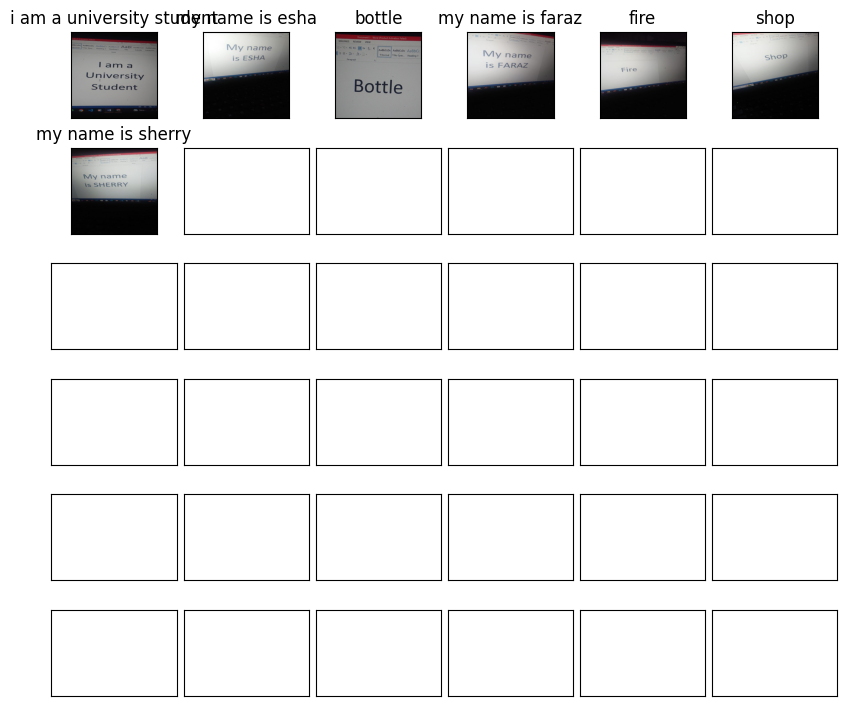

In [ ]:
# Display sample images
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    # Check if the index 'i' is within the bounds of the DataFrame
    if i < len(df_unique):
        ax.imshow(plt.imread(df_unique.Filepath[i]))
        ax.set_title(df_unique.Label[i], fontsize=12)
    else:
        # If index is out of bounds, break the loop to avoid the error
        break
plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [ ]:
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
# Create image generators
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0
)

Found 848 validated image filenames belonging to 7 classes.


In [ ]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0
)

Found 389 validated image filenames belonging to 7 classes.


In [ ]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 477 validated image filenames belonging to 7 classes.


In [ ]:
# Model setup with fine-tuning and additional layers
num_classes = len(train_df.Label.unique())
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
pretrained_model.trainable = True
for layer in pretrained_model.layers[:-20]:  # Freeze all layers except the last 20
    layer.trainable = False

In [ ]:
inputs = pretrained_model.input
x = tf.keras.layers.Dense(512, activation='relu')(pretrained_model.output)  # Increased dense layer size
x = tf.keras.layers.Dropout(0.5)(x)  # Add dropout to reduce overfitting
x = tf.keras.layers.Dense(512, activation='relu')(x)  # Increased dense layer size
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)


In [ ]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Lower learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Model training with EarlyStopping and Learning Rate Scheduling
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
]

In [ ]:
# Train the model
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=15,  # Increased epochs for better training
    batch_size=32,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 373s 13s/step - accuracy: 0.2181 - loss: 1.9040 - val_accuracy: 0.3625 - val_loss: 1.6965 - learning_rate: 1.0000e-04
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 24s 901ms/step - accuracy: 0.5829 - loss: 1.2913 - val_accuracy: 0.4370 - val_loss: 1.3850 - learning_rate: 1.0000e-04
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 720ms/step - accuracy: 0.7069 - loss: 0.8851 - val_accuracy: 0.4679 - val_loss: 1.2162 - learning_rate: 1.0000e-04
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 775ms/step - accuracy: 0.7921 - loss: 0.6016 - val_accuracy: 0.4499 - val_loss: 1.4153 - learning_rate: 1.0000e-04
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 713ms/step - accuracy: 0.8155 - loss: 0.4923 - val_accuracy: 0.4833 - val_loss: 1.2107 - learning_rate: 1.0000e-04
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 730ms/step - accuracy: 0.8729 - loss: 0.3650 - val_accuracy: 0.6041 - val_loss: 0.9810 - learning_rate: 1.0000e-04
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 742ms/step - accu

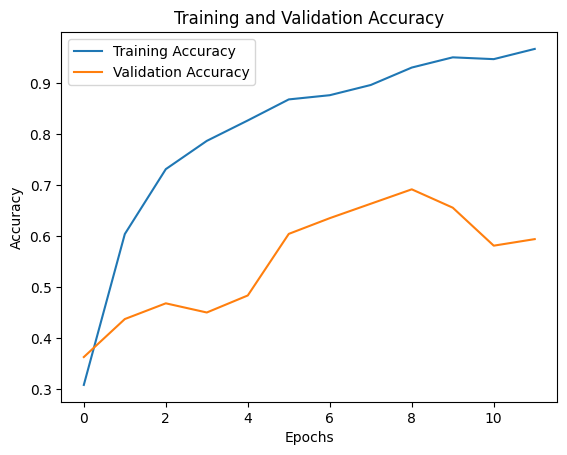

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:
# Print final accuracy
print(f"Final Training Accuracy: {history.history['accuracy'][-1]}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]}")


Final Training Accuracy: 0.9669811129570007
Final Validation Accuracy: 0.5938303470611572


In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

15/15 ━━━━━━━━━━━━━━━━━━━━ 118s 8s/step


['my name is sherry',
 'shop',
 'i am a university student',
 'bottle',
 'bottle',
 'shop',
 'my name is faraz',
 'my name is faraz',
 'my name is faraz',
 'my name is esha',
 'my name is sherry',
 'i am a university student',
 'my name is sherry',
 'bottle',
 'bottle',
 'i am a university student',
 'bottle',
 'my name is sherry',
 'my name is sherry',
 'fire',
 'bottle',
 'bottle',
 'shop',
 'my name is esha',
 'my name is esha',
 'shop',
 'bottle',
 'my name is faraz',
 'bottle',
 'my name is faraz',
 'shop',
 'shop',
 'my name is faraz',
 'bottle',
 'bottle',
 'i am a university student',
 'shop',
 'my name is faraz',
 'my name is faraz',
 'i am a university student',
 'my name is esha',
 'my name is faraz',
 'my name is sherry',
 'i am a university student',
 'bottle',
 'my name is sherry',
 'my name is sherry',
 'my name is faraz',
 'my name is sherry',
 'bottle',
 'bottle',
 'shop',
 'bottle',
 'i am a university student',
 'my name is faraz',
 'i am a university student',
 'bot

In [ ]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [ ]:
# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('/content/textual_model.tflite', 'wb') as f:
    f.write(tflite_model)

# Save the class labels to a text file
with open('/content/textual_labels.txt', 'w') as f:
    for label in labels.values():
        f.write(f"{label}\n")

# Download the TFLite model
from google.colab import files
files.download('/content/textual_model.tflite')

# Download the labels file
files.download('/content/textual_labels.txt')

Saved artifact at '/tmp/tmpjc_83q5b'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  139352830664656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139352830665616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139352830667152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139352830666768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139352830665424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139352830667344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139352830666384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139352830664272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139352830667536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139352830665232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13935283066792

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
img = output('/content/drive/MyDrive/textualdataset/test/i am a university student/IMG-20250127-WA0003_jpg.rf.06781546e7288fd9979f07bdd859ecfa - Copy (3).jpg')
print(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
i am a university student
